### PSO algoritam

In [1]:
import random
import time

In [2]:
import codecs

def parse_dimacs_to_list(graph_file_name):
    
    graph_list = []
    dim = 0

    with codecs.open(graph_file_name, encoding='ascii') as graph_text:
    
        for line in graph_text:
            if line.startswith('e'):
                line = line[:-2]  
                line = line.split(' ')
                del line[0]    
                int_list = list(map(int,line))
                dim = max(dim, int(int_list[0]), int(int_list[1]))

        print('Dimenzija: ',dim)

        for i in range(0,dim+1):
            graph_list.append([])
        

    #popunjavanje liste
    with codecs.open(graph_file_name, encoding='ascii') as graph_text:        

        for line in graph_text:
            if line.startswith('e'):
                #print(line)
                line = line[:-2]  
                line = line.split(' ')
                del line[0]    
                int_list = list(map(int,line))
                #print(int_list)
                #print(int_list[0],int_list[1])
                graph_list[int_list[0]].append(int_list[1])
                graph_list[int_list[1]].append(int_list[0])
                #print(graph_list)


    return graph_list


In [3]:
def transpose(graph):
    for n, i in enumerate(graph):
        for m, j in enumerate(i):
            graph[n][m] = j - 1

In [4]:
graph0 = [[3],[3],[3],[0,1,2,4],[3,5,6,7],[4],[4],[4]]

#mali (4)
graph1 = parse_dimacs_to_list('graph1.txt')
graph1.pop(0) 
transpose(graph1)
#print(graph1)

#srednji (6)
graph2 = parse_dimacs_to_list('graph2.txt')
graph2.pop(0) 
transpose(graph2)
#print(graph2)

#srednje boja mnogo cvorova (20)
graph3 = parse_dimacs_to_list('graph3.txt')
graph3.pop(0) 
transpose(graph3)
#print(graph3)

#mnogo boja mnogo cvorova  (42)
graph4 = parse_dimacs_to_list('graph4.txt')
graph4.pop(0) 
transpose(graph4)
#print(graph4)

#mnogo covrova malo boja (8)
graph5 = parse_dimacs_to_list('graph5.txt')
graph5.pop(0) 
transpose(graph5)
#print(graph5)

#mnogo cvorova malo grana (9)
graph6 = parse_dimacs_to_list('graph6.txt')
graph6.pop(0) 
transpose(graph6)
#print(graph6)

Dimenzija:  11
Dimenzija:  47
Dimenzija:  128
Dimenzija:  128
Dimenzija:  95
Dimenzija:  120


#### Znacajni parametri

In [5]:
W = 0.75
C1 = 1.5 #ne menjati puno, videla u nekom radu da je optimalna tezina uvek oko 2.0
C2 = 2.0

In [6]:



def isFeasible(graph, solution):
    for i in range(len(graph)):
        for neigh in graph[i]:
            if(solution[i]==solution[neigh]):
                return False
            
    return True

def findAjdColors(i,graph,colors):
        ajdColors = []
        for ajd in graph[i]:
            ajdColors.append(colors[ajd])
        return ajdColors
        
        
def correctNonFeasible(graph,colors):
        
    for i in range(len(graph)):
        ajdColors = findAjdColors(i,graph,colors)
        if(colors[i] in ajdColors):  
            possibleColors = list(set(list(range(1,len(colors)+1)))-set(ajdColors))
            #difference = []
            #for x in possibleColors:
            #    difference.append(abs(colors[i]-x))
            #minDifference = float('inf')
            #pos = 0
           # for i in range(len(difference)):
            #    if difference[i] < minDifference:
             #       minDifference = difference[i]
              #      pos = i
            colors[i] = random.choice(possibleColors)
            #colors[i] = possibleColors[pos]
                


def initializeSolution(graph):
    colors = []
    numberOfColors = len(graph)
    for i in range(numberOfColors):
            colors.append(random.randrange(1,numberOfColors+1))
    
    if not isFeasible(graph,colors):
        correctNonFeasible(graph,colors)
        
    return colors

# racuna vrednost funkcije cilja
def solutionValue(solution):
    return sum(solution)

In [7]:
def init(numberVertex,position,velocity,bestValue,numberOfParticles,graph):
    # za svaku cesticu pravimo bojenje
    globalBestValue = float("inf")
    for i in range(numberOfParticles):
        coloring = initializeSolution(graph)
        position.append(coloring)
        bestValue.append(solutionValue(coloring))
        velocity.append(0.0)
        if(solutionValue(coloring)<globalBestValue):
            globalBestValue = solutionValue(coloring)
            globalBest = coloring

    return globalBestValue,globalBest    
        
        

In [8]:
#apdejtujemo vektor brzina


def updateVelocity(position,velocity,bestValue,globalBestValue,graph):
    # za svaku jedinku
    for i in range(len(velocity)):
        # po formuli 
        #              koliko pridajemo znajacnosti      pravac
        cognitiveVelocity = C1*random.random()*(bestValue[i]-solutionValue(position[i]))
        socialVelocity = C2 *random.random()*(globalBestValue-solutionValue(position[i]))
        velocity[i] = W * velocity[i] + cognitiveVelocity + socialVelocity
        if velocity[i] > len(graph): 
            velocity[i] = len(graph)
        if velocity[i] < -len(graph):
            velocity[i] = -len(graph)

In [9]:
def updatePosition(position,velocity,bestValue,globalBest,globalBestValue,graph):
    # za svaku cesticu
    for i in range(len(position)):
        # prolazimo kroz svaki deo koloringa, na svaki broj dodajemo brzinu
        # isto formula
        for j in range(len(position[i])):
            position[i][j]+=int(velocity[i])#jer nam trebaju celi brojevi, necemo velocity jer bismo stalno zaokruzili i usporili
            if position[i][j] > len(graph):
                position[i][j] = len(graph)
            if position[i][j] < 1:
                position[i][j] = 1

        if not isFeasible(graph,position[i]):
            correctNonFeasible(graph,position[i])
        value = solutionValue(position[i])
        if value < bestValue[i]:
            bestValue[i]=value
        if value<globalBestValue:
            globalBestValue = value
            globalBest = position[i].copy()
        
        
    return globalBestValue, globalBest    
            
    

In [10]:


def PSO(graph,numberVertex,numberOfParticles,maxIteration):
    position = []   #niz svih bojenja
    velocity = []  # vektor brzina
    bestValue = [] #vektor najboljih pozicija za svaku cesticu
    
    globalBestValue,globalBest = init(len(graph),position,velocity,bestValue,numberOfParticles,graph)
    for iteration in range(maxIteration):
        #apdejtujemo brzinu
        updateVelocity(position,velocity,bestValue,globalBestValue,graph)
        globalBestValue, globalBest = updatePosition(position,velocity,bestValue,globalBest,globalBestValue,graph)
        
    return globalBestValue, globalBest
    
    

### Primena algoritma na razlicite grafove

In [11]:
import matplotlib.pyplot as plt
import numpy as np

graph0
Sec: 0.004876499999909356
Unique colors: 3
Sum: 11

graph1
Sec: 0.009538499999962369
Unique colors: 6
Sum: 37

graph2
Sec: 0.06620320000001811
Unique colors: 20
Sum: 657

graph3
Sec: 0.33205920000000333
Unique colors: 75
Sum: 5609

graph4
Sec: 0.580711699999938
Unique colors: 88
Sum: 6724

graph5
Sec: 0.1912328000000798
Unique colors: 50
Sum: 2404

graph6
Sec: 0.2616594000000987
Unique colors: 65
Sum: 3967

graph0
Sec: 0.05171949999999015
Unique colors: 3
Sum: 16

graph1
Sec: 0.0898234000001139
Unique colors: 5
Sum: 39

graph2
Sec: 0.6082808000001023
Unique colors: 22
Sum: 527

graph3
Sec: 3.558870799999795
Unique colors: 73
Sum: 5637

graph4
Sec: 5.850787200000013
Unique colors: 85
Sum: 5968

graph5
Sec: 2.0361806000000797
Unique colors: 46
Sum: 2151

graph6
Sec: 2.5249522999999954
Unique colors: 69
Sum: 5453

graph0
Sec: 0.49752500000022337
Unique colors: 3
Sum: 11

graph1
Sec: 0.91848200000004
Unique colors: 5
Sum: 30

graph2
Sec: 6.212408299999879
Unique colors: 22
Sum: 503


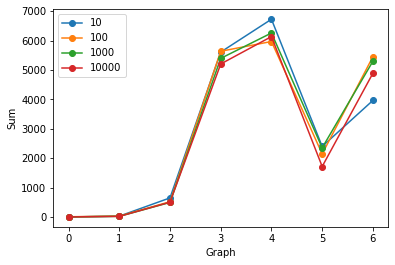

In [12]:
graph_names = ['graph0', 'graph1', 'graph2', 'graph3', 'graph4', 'graph5', 'graph6']
graph_list = [graph0, graph1, graph2, graph3, graph4, graph5, graph6]
unique_colors = []
#sums0, sums1, sums2, sums3, sums4, sums5, sums6 = [],[],[],[],[],[],[]
#sum_list = [sums0, sums1, sums2, sums3, sums4, sums5, sums6]
sum_list = []
compare_list = []

for size in [10,100,1000,10000]:
    for graph, name in zip(graph_list, graph_names):

        start = time.perf_counter()
        value, solution = PSO(graph,len(graph),20,size)
        end = time.perf_counter()
        timeExec = end - start
        unique_colors.append(len(set(solution)))
        sum_list.append(value)
        
        print(name)
        print('Sec: ' + str(timeExec))
        print('Unique colors: ' + str(len(set(solution))))
        print('Sum: ' + str(value))

        print()
    compare_list.append(unique_colors)
    unique_colors = []
        
    plt.plot([0,1,2,3,4,5,6], sum_list, '-o',label=size)
    plt.legend(loc='upper left')        
        
    sum_list = []
plt.xlabel("Graph")
plt.ylabel("Sum")
plt.savefig('pso.png')
plt.show()        
        
        

graph0
Sec: 0.012064999999893189
Unique colors: 3
Sum: 15

graph1
Sec: 0.022354400000040187
Unique colors: 6
Sum: 36

graph2
Sec: 0.14390499999990425
Unique colors: 30
Sum: 824

graph3
Sec: 0.7835829000005106
Unique colors: 75
Sum: 5721

graph4
Sec: 1.3816828999997597
Unique colors: 93
Sum: 6836

graph5
Sec: 0.4507381000003079
Unique colors: 47
Sum: 2003

graph6
Sec: 0.5990717000004224
Unique colors: 72
Sum: 5182

graph0
Sec: 0.0252280000004248
Unique colors: 3
Sum: 12

graph1
Sec: 0.04334219999964262
Unique colors: 6
Sum: 33

graph2
Sec: 0.30833289999918634
Unique colors: 22
Sum: 580

graph3
Sec: 1.6565570999991905
Unique colors: 80
Sum: 6319

graph4
Sec: 2.7045907000001534
Unique colors: 89
Sum: 6499

graph5
Sec: 0.9834319000001415
Unique colors: 55
Sum: 3338

graph6
Sec: 1.337544799999705
Unique colors: 72
Sum: 4422

graph0
Sec: 0.03710330000012618
Unique colors: 3
Sum: 15

graph1
Sec: 0.0703696000000491
Unique colors: 5
Sum: 33

graph2
Sec: 0.49514799999997194
Unique colors: 24
Sum

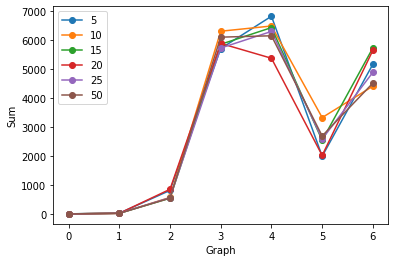

In [13]:
graph_names = ['graph0', 'graph1', 'graph2', 'graph3', 'graph4', 'graph5', 'graph6']
graph_list = [graph0, graph1, graph2, graph3, graph4, graph5, graph6]
unique_colors = []
#sums0, sums1, sums2, sums3, sums4, sums5, sums6 = [],[],[],[],[],[],[]
#sum_list = [sums0, sums1, sums2, sums3, sums4, sums5, sums6]
sum_list = []
compare_list = []

for p in [5,10,15,20,25,50]:
    for graph, name in zip(graph_list, graph_names):

        start = time.perf_counter()
        value, solution = PSO(graph,len(graph),p,100)
        end = time.perf_counter()
        timeExec = end - start
        unique_colors.append(len(set(solution)))
        sum_list.append(value)
        
        print(name)
        print('Sec: ' + str(timeExec))
        print('Unique colors: ' + str(len(set(solution))))
        print('Sum: ' + str(value))

        print()
    compare_list.append(unique_colors)
    unique_colors = []
        
    plt.plot([0,1,2,3,4,5,6], sum_list, '-o',label=p)
    plt.legend(loc='upper left')        
        
    sum_list = []
plt.xlabel("Graph")
plt.ylabel("Sum")
plt.savefig('pso2.png')
plt.show()   